In [25]:
import pandas as pd 
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import numpy as np

In [14]:
df = pd.read_csv('mystery_planet02.txt', header=None, names=['t', 'f', 'f_err'], delim_whitespace=True)

# Q1

# Q2
First some helper functions that express the area of overlap and the fraction of flux visible (formulas taken from Mandel and Agol, 2002).

In [475]:
def frac_overlap(b, k):
    k1 = np.arccos((1 - k ** 2 + b ** 2) / (2 * b))
    k0 = np.arccos((k ** 2 + b ** 2 - 1) / (2 * k * b))
    return 1 / np.pi * (k ** 2 * k0 + k1 - 
                        np.sqrt((4 * b ** 2 - 
                                 (1 + b ** 2 - k ** 2) **2)/4))

def norm_flux_visible(b, k):
    f = np.ones(len(b))
    fully_trans = b <= 1 - k
    partial_trans = ((b <= 1 + k) & (np.abs(1 - k) < b))
    f[fully_trans] = 1 - k ** 2
    f[partial_trans] = 1 - frac_overlap(b[partial_trans], k)
    return f

Transit model definition

In [ ]:
def transit_model(t, t0, T, k, b0, P, F0):
    t_fold = t % P
    v = 2 / T * np.sqrt((1 + k) ** 2 - b0 ** 2)
    b = np.sqrt(b0 ** 2 + (v * (t_fold - t0)) ** 2)
    return F0 * norm_flux_visible(b, k)
    

Example transits

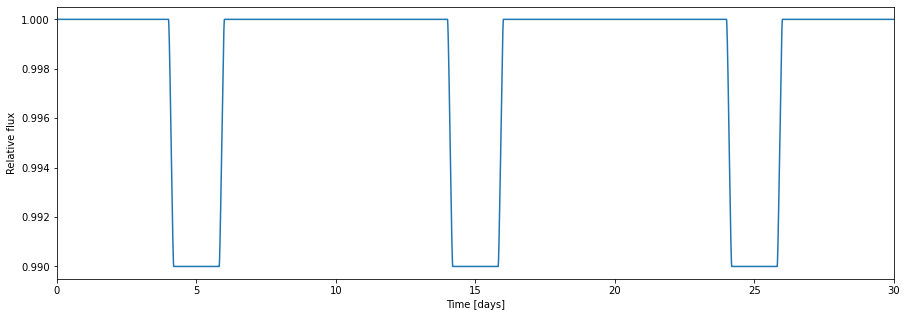

In [476]:
fig, ax = plt.subplots(figsize=(15, 5))

t_range = np.linspace(0, 30, 10000)
flux = transit_model(t_range, t0=5, b0=0.1, T=2, k=0.1, P=10, F0=1)

ax.plot(t_range, flux)

ax.set_xlim(t_range.min(), t_range.max())
ax.set_xlabel("Time [days]")
ax.set_ylabel("Relative flux")

plt.show()

# Q3

Using the small planet approximation, we redefine our flux visible calculation

In [ ]:
def limb_darkened_flux_visible(b, k, u1, u2):
    r = np.abs(b)
    f = np.ones(len(b))
    fully_trans = b <= 1 - k
    partial_trans = ((b <= 1 + k) & (np.abs(1 - k) < b))

    
    mu = np.zeros(len(r))
    transiting = (r >= 0) & (r <= 1)
    mu[transiting] = np.sqrt(1 - r[transiting] ** 2)
    limb_darkening = (1 - u1 * (1 - mu) - u2 * (1 - mu) ** 2) /(1 - u1 / 3 - u2 / 6) 
    
    f[fully_trans] = 1 - (k ** 2 * limb_darkening[fully_trans])
    f[partial_trans] = 1 - frac_overlap(b[partial_trans], k) * limb_darkening[partial_trans]
    return f

def limb_darkened_model(t, t0, T, k, b0, P, F0, u1, u2):
    t_fold = t % P
    v = 2 / T * np.sqrt((1 + k) ** 2 - b0 ** 2)
    b = np.sqrt(b0 ** 2 + (v * (t_fold - t0)) ** 2)
    return F0 * limb_darkened_flux_visible(b, k, u1, u2)


In [ ]:
fig, ax = plt.subplots(figsize=(25, 5))

t_range = np.linspace(0, 30, 10000)

for u1, u2, lw in zip([0, 0.5, 0.5],[0, 0, 0.5], [2, 2, 2]):
    flux = limb_darkened_model(t_range, t0=5, b0=0.1, T=5, k=0.1, P=10, F0=1, u1=u1, u2=u2)
    plt.plot(t_range, flux, lw=lw)

ax.set_xlim(t_range.min(), t_range.max())
ax.set_xlabel("Time [days]")
ax.set_ylabel("Relative flux")

plt.show()

# Q4

### Find the period
First we find the period. To do this I will smooth the data and plot it:

In [325]:
win_size = 7
df['smooth_f'] = df['f'].rolling(win_size, win_type='triang', min_periods=1).mean()
df['smooth_f_err'] = df['f_err'].rolling(win_size, win_type='triang', min_periods=1).mean() / np.sqrt(win_size)

<AxesSubplot:xlabel='t'>

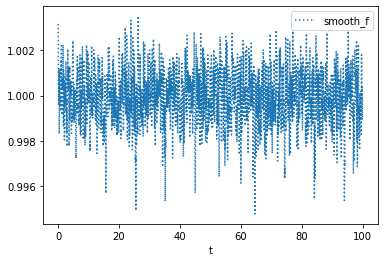

In [326]:
df.plot(x='t', y='smooth_f', ls=':')

looks like the theres a transit every 10 or so days

### Periodogram

In [329]:
freq, power = LombScargle(df['t'], 
                          df['smooth_f'], 
                          dy=df['f_err'], nterms=3
                         ).autopower(minimum_frequency=.05, 
                                     maximum_frequency=.15, 
                                     samples_per_peak=10)

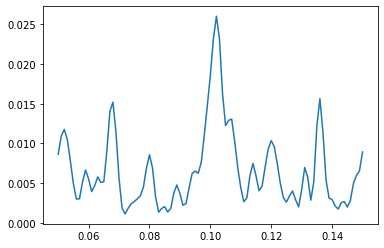

In [330]:
plt.plot(freq, power)

In [331]:
f_ls = freq[np.argmax(power)]
1/f_ls

So the frequency is around 9.804 days. Plotting a folded lightcurve of the smoothed data:

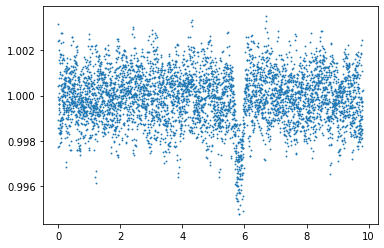

In [333]:
plt.scatter(df['t']%(1/f_ls), df['smooth_f'], s=.7)

In [335]:
df['ntrans'] = (df['t'] / (1/f_ls)).astype(int)

In [336]:
df['t_fold'] = df['t'] % (1/f_ls)

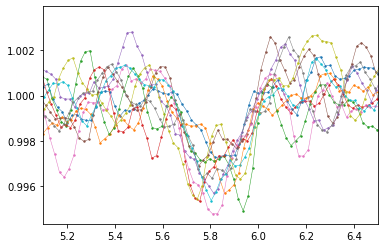

In [347]:
for ii in df['ntrans'].unique():
    sub = df.query(f'ntrans == {ii}')
    plt.plot(sub['t_fold'], sub['smooth_f'], lw=.5)
    plt.scatter(sub['t_fold'], sub['smooth_f'],s=2)
plt.xlim([5.1, 6.5])
plt.show()

### Experiment (not part of final answer)
Smooth the folded lightcurve and fit using curve_fit from scipy.optimize.

In [176]:
t_fold, f1 = df['t']%(1/f_ls), df['smooth_f']

In [353]:
ts = (df['t']%(1/f_ls)).loc[folded_inds].values
fs_raw = df['f'].loc[folded_inds].values
f_err_raw = df['f_err'].loc[folded_inds].values

In [364]:
fs = pd.Series(fs_raw).rolling(50, min_periods=1).mean()
f_errs = pd.Series(f_err_raw).rolling(50, min_periods=1).mean() / np.sqrt(50)

##### The smoothed, folded lightcurve

(5.5, 6.1)

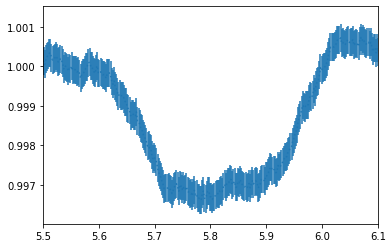

In [357]:
plt.errorbar(ts, fs, f_errs, fmt=':')
plt.xlim([5.5, 6.1])

This lightcurve may extend the time and shape of ingress/egress because of the smoothing, so all fits should be taken with a grain of salt

In [352]:
from scipy.optimize import curve_fit

In [386]:
popt, pcov = curve_fit(limb_darkened_model, ts, fs, p0=(5.8, .35, .001, .3, 9.803, 1, 0, 0), 
                       bounds = ([5.7, .2, .001, 0,9.75, .998, 0, 0], 
                                [5.9, .5, .1, 1,9.85, 1.002, .5, 1]), sigma=f_errs ,maxfev=5000)

In [387]:
popt

array([5.81193534e+00, 4.06228455e-01, 6.04604912e-02, 9.19942685e-01,
       9.75050000e+00, 9.99994922e-01, 4.40321095e-01, 5.35086990e-05])

In [389]:
 t0, T, k, b0, P, F0, u1, u2 = popt

In [478]:
k

0.061228279851651905

In [390]:
(3/np.pi**2 * P/(G*T**3*u.day**2)*((1-b0**2)**1.5)).cgs

<Quantity 0.00534734 g / cm3>

(5.5, 6.1)

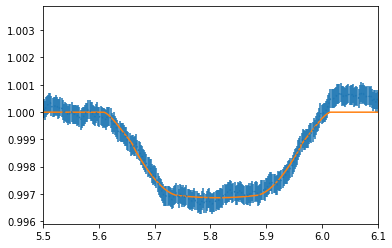

In [388]:
plt.errorbar(ts, fs, f_errs, fmt=':')
plt.plot(ts, limb_darkened_model(ts, *popt))
plt.xlim([5.5, 6.1])

In [486]:
f2, t0, T, k, b0, P, F0, u1, u2 = init

In [487]:
k

0.06046049116351773

In [488]:
def log_likelihood(theta, t, f, f_err):
    # return gaussian log likelihood of data given model params theta
    f2 = theta[0] # add an overall error term
    model = limb_darkened_model(t, *theta[1:])
    f_err2 = f_err ** 2 
    return -0.5 * np.sum((f - model) ** 2 / f_err2 + np.log(f2))

def log_prior(theta):
    # return -inf if params outside of priors, else return 0
    # f2, t0, T, k, b0, P, F0, u1, u2 = theta
    bounds = ([1e-10, 5.7, .2, .0001, 0,9.75, .998, 0, 0], [1e-2, 5.9, .5, .1, 1,9.85, 1.002, .5, 1])
    if sum([bounds[0][i] < param < bounds[1][i] for i, param in enumerate(theta)]) == len(theta):
        return 0.0
    return -np.inf

def log_probability(theta, t, rv, rv_err):
    # sum of logL and log Priors
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, rv, rv_err)

In [489]:
# initialize values from least squares fit
init = np.ones(9) * 1e-3
init[1:] = popt

In [490]:
np.random.seed(1)
pos = init + 1e-4 * np.random.randn(18, 9) # initialize starting positions of 16 walkers
nwalkers, ndim = pos.shape

# run MCMC
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, 
    args=(df['t'], df['smooth_f'], df['smooth_f_err'])
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|                                                                                                                                                                              | 0/5000 [00:00<?, ?it/s]/Users/ykwang/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:30<00:00, 33.29it/s]


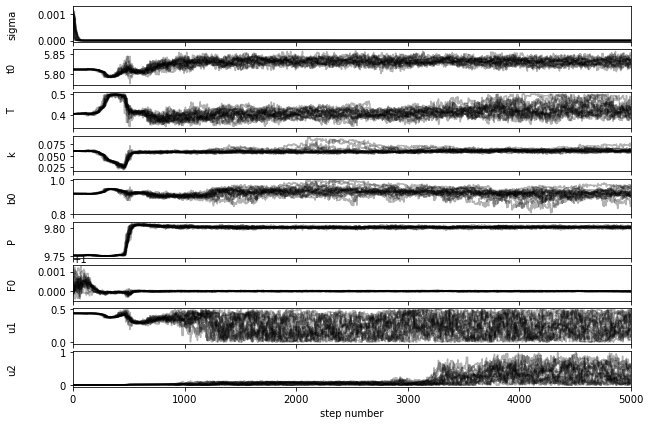

In [491]:
fig, axes = plt.subplots(9, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['sigma', 't0', 'T', 'k', 'b0', 'P', 'F0', 'u1', 'u2']
for i in range(9):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


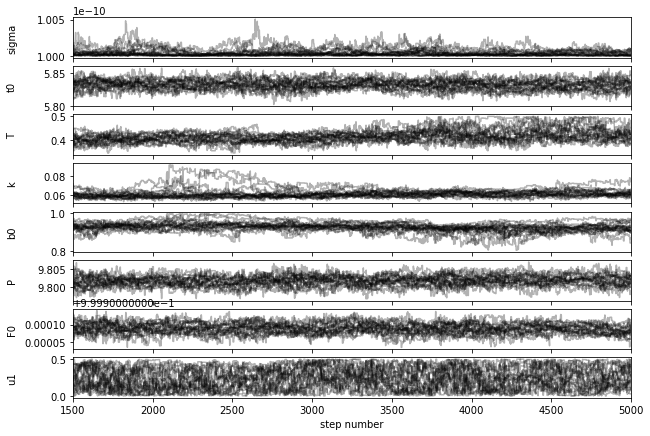

In [493]:
burnin = 1500
fig, axes = plt.subplots(8, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burnin)
for i in range(8):
    ax = axes[i]
    ax.plot(range(burnin, burnin + len(samples)), samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(burnin, burnin + len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


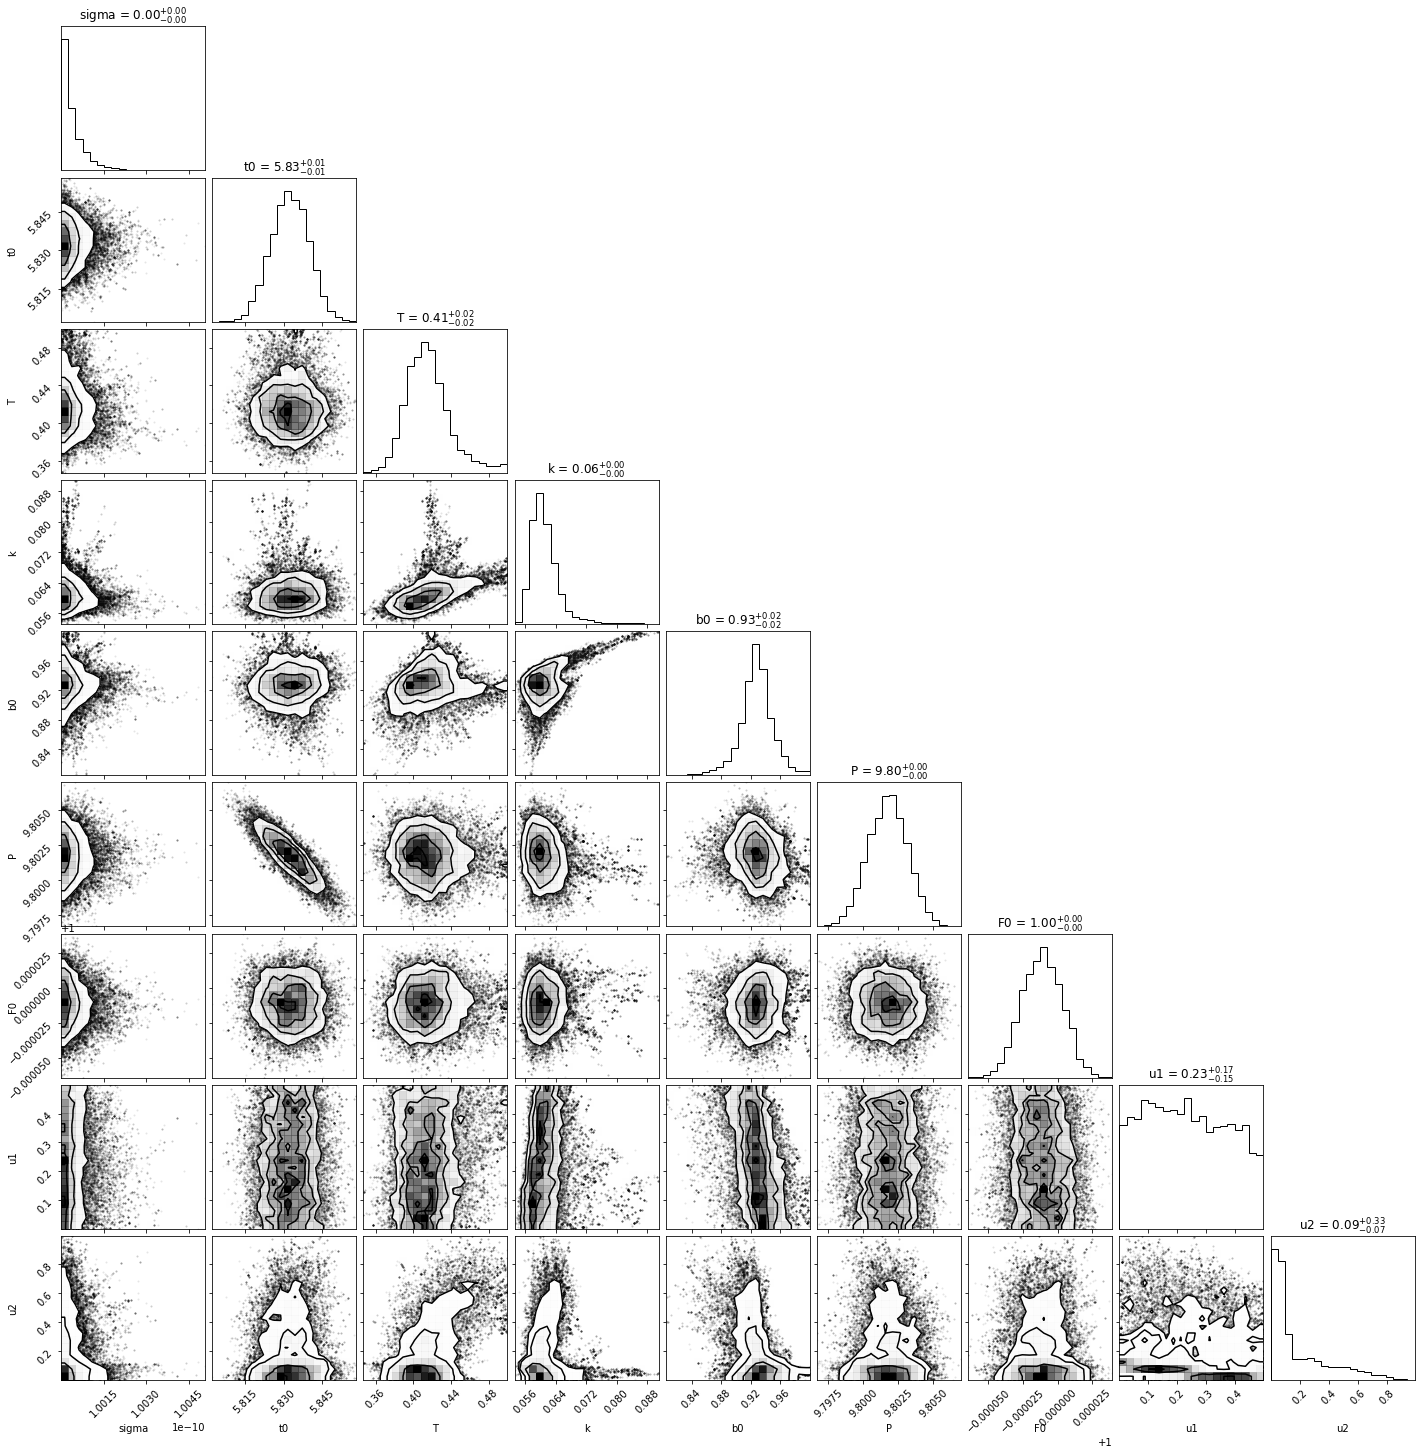

In [494]:
import corner

flat_samples = sampler.get_chain(discard=burnin, flat=True)
fig = corner.corner(
    flat_samples, labels=labels, show_titles=True
);

In [495]:
fit = flat_samples.mean(axis=0)
fit = np.median(flat_samples, axis=0)
for ii, param in enumerate(fit):
    print(labels[ii].ljust(10), round(param, 3))

sigma      0.0
t0         5.832
T          0.414
k          0.06
b0         0.928
P          9.802
F0         1.0
u1         0.231
u2         0.093


In [496]:
dens = []
for i in range(1000):
    sigma, t0, T, k, b0, P, F0, u1, u2 = flat_samples[np.random.randint(10000, 63000)]
    dens.append((3/np.pi**2 * P/(G*T**3*u.day**2)*((1-b0**2)**1.5)).cgs.value)

(array([ 49., 273., 378., 163.,  70.,  36.,  23.,   3.,   1.,   4.]),
 array([8.01431901e-06, 1.76337195e-03, 3.51872958e-03, 5.27408721e-03,
        7.02944484e-03, 8.78480247e-03, 1.05401601e-02, 1.22955177e-02,
        1.40508754e-02, 1.58062330e-02, 1.75615906e-02]),
 <BarContainer object of 10 artists>)

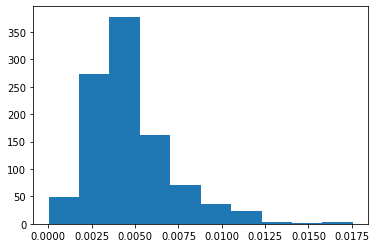

In [497]:
plt.hist(dens)

In [498]:
sigma, t0, T, k, b0, P, F0, u1, u2  = fit

In [499]:
(3/np.pi**2 * P/(G*T**3*u.day**2)*((1-b0**2)**1.5)).cgs

<Quantity 0.00438444 g / cm3>

(5.5, 6.1)

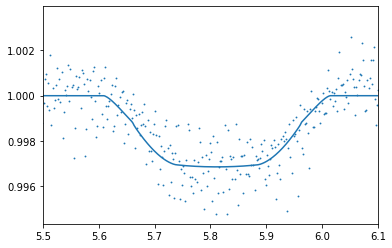

In [500]:
# plt.errorbar(ts, fs, f_errs, fmt=':')
plt.scatter(df['t']%(1/f_ls), df['smooth_f'], s=.7)
plt.plot(ts, limb_darkened_model(ts, *popt))
plt.xlim([5.5, 6.1])